# Preprocessing Module
The primary purpose of this module is to gather, preprocess, split all of the data that will be used for our model.

# Import Libraries

In [2]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Basic Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from io import BytesIO


# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image Libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import lime
from lime import lime_image
#import cv2  # Import cv2 for image processing
from skimage.transform import resize
import pickle


2024-04-22 02:57:31.804324: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-04-22 02:57:31.804362: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Functions
Below you can find three for conducting the preprocessing:
- **set_limiting_factor()**: To assure balanced data in the preprocessed dataset, you can use this function to feed in the directory paths to the datasets to return the number of images in the shortest dataset. This allows you to select the number of images you want to use from each dataset without having to pull in the all of images.
- **preprocess_images()**:
  - Takes the path to the dataset of interest, the label you want for the dataset, and the limiting factor for the number of images to take.
  - Preprocesses the images by resizing.
  - Produces a sample of newly preprocessed images.
  - Splits them into train, validation, and test at an 80%/10%/10% split.
  - Returns the images and their respective labels.
- **preprocessing_images_bulk()**
  - Takes a list of paths to multiple datasets, labels for each of them, and the limiting factor.
  - Preprocesses each dataset using preprocess_images().
  - Combines the split datasets.
  - Returns the split datasets.

In [5]:
def set_limiting_factor(s3_client, bucket_name, dataset_paths):
    '''Pass a list of S3 directory paths to return the length of the shortest one.'''
    limiting_factors = []
    for dataset_path in dataset_paths:
        response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=dataset_path)
        image_files = [obj['Key'] for obj in response.get('Contents', []) if obj['Key'].endswith(('.jpeg', '.jpg', '.png'))]
        limiting_factors.append(len(image_files))
    limiting_factor = min(limiting_factors)
    print(f'Limiting Factor of Datasets: {limiting_factor}')
    return limiting_factor

In [6]:
# Function to preprocess the images in a given directory
def preprocess_images(image_files, label, s3_client, bucket, limiting_factor=100):
    images = []
    labels = []
    count = 0
    
    for file_key in image_files:
        if count >= limiting_factor:
            break  # Exit the loop if we've processed enough images

        response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
        image = Image.open(BytesIO(response['Body'].read()))
        
        if image.mode != "L":
            image = image.convert("L")    # Convert grayscale to grayscale
        image = image.resize((256, 256))  # Resize images to 256x256 pixels
            
            # Normalize pixel values to [0, 1]
            #image = np.array(image) / 255.0
            #min_val = np.min(image_array)
            #max_val = np.max(image_array)
            #image_array_normalized = (image_array - min_val) / (max_val - min_val + 1e-9)  # Add small value to avoid division by zero
        
        image_np = np.array(image) / 255.0

        images.append(image_np)
        labels.append(label)
        count += 1
        if (count % round((limiting_factor/4)) == 0) | (count == limiting_factor):
            print(f'Processed: {count}/{limiting_factor} images for {label}')
    
    # Display sample images from each class
    plt.figure(figsize=(12, 5))
    for i in range(5):
        plt.subplot(3, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label {label}, Sample {i + 1}")
        plt.axis("off")
    plt.show()
    
    # Convert lists to numpy arrays
    images = np.stack(images)
    labels = np.array(labels)
    
    # Split the data into train/validation/test split of 80/10/10
    train_images, test_images, \
    train_labels, test_labels \
    = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
    
    validation_images, test_images, \
    validation_labels, test_labels \
    = train_test_split(test_images, test_labels, test_size=0.5, random_state=42, stratify=test_labels)
        
    return train_images, validation_images, test_images, \
           train_labels, validation_labels, test_labels

In [7]:
# Function to preprocess images from multiple directories with respective labels
def preprocess_images_bulk(image_dir_list, label_list, limiting_factor=100):
    train_images = []
    validation_images = []
    test_images = []
    train_labels = []
    validation_labels = []
    test_labels = []
    
    for image_dir, label in zip(image_dir_list, label_list):
        image_files = list_s3_objects(bucket_name, image_dir)
        
        train_images_i, validation_images_i, test_images_i, \
        train_labels_i, validation_labels_i, test_labels_i \
        = preprocess_images(image_files, label, limiting_factor=limiting_factor, s3_client=s3, bucket=bucket_name)
        
        # Append images from current directory to the list
        train_images.extend(train_images_i) 
        validation_images.extend(validation_images_i)
        test_images.extend(test_images_i)
        
        # Append labels from current directory to the list
        train_labels.extend(train_labels_i)
        validation_labels.extend(validation_labels_i)
        test_labels.extend(test_labels_i)
        
    return train_images, validation_images, test_images, \
           train_labels, validation_labels, test_labels

In [8]:
# Function to list the obnjects in the S3 bucket given a prefix
def list_s3_objects(bucket, prefix):
    response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
    return [obj['Key'] for obj in response.get('Contents', []) if obj['Key'].endswith('.jpg')]

# Datasets

In [9]:
import boto3

s3 = boto3.client('s3')
#S3 bucket
bucket_name = 'sagemaker-team6-distracted-drivers'

# Classes
class_paths = [f'Imgs/train/c{i}/' for i in range(10)]

/home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


## List the paths, set the labels, and set the limiting factor for each respective dataset of interest

In [10]:
# Main Model Dataset
#class_paths = [c0_dir, c1_dir, c2_dir, c3_dir, c4_dir, c5_dir, c6_dir, c7_dir, c8_dir, c9_dir]
class_labels = [0,1,2,3,4,5,6,7,8,9]
#class_labels = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
class_lf = set_limiting_factor(s3, bucket_name, class_paths)

# Ran with smaller limiting factor

#model_inputs = class_paths, class_labels, class_lf
model_inputs = class_paths, class_labels

Limiting Factor of Datasets: 1000


## Process, Split, and Save the Ensemble Main Model Datasets

Processed: 25/100 images for 0
Processed: 50/100 images for 0
Processed: 75/100 images for 0
Processed: 100/100 images for 0


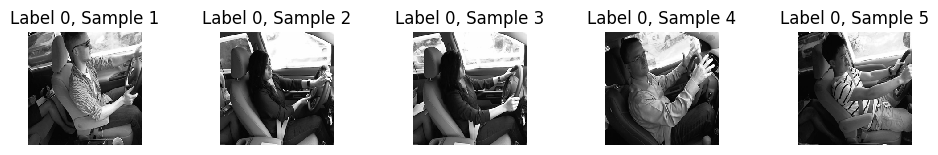

Processed: 25/100 images for 1
Processed: 50/100 images for 1
Processed: 75/100 images for 1
Processed: 100/100 images for 1


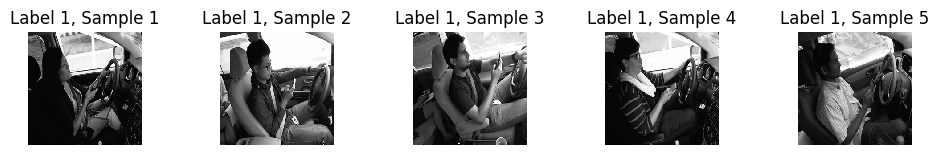

Processed: 25/100 images for 2
Processed: 50/100 images for 2
Processed: 75/100 images for 2
Processed: 100/100 images for 2


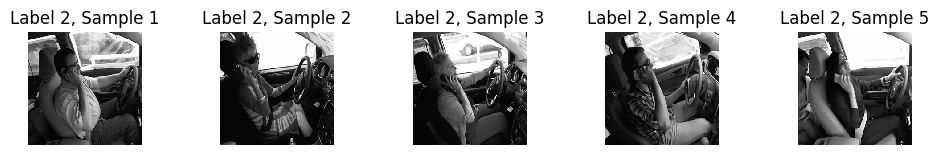

Processed: 25/100 images for 3
Processed: 50/100 images for 3
Processed: 75/100 images for 3
Processed: 100/100 images for 3


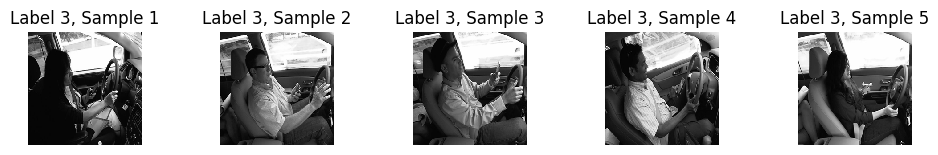

Processed: 25/100 images for 4
Processed: 50/100 images for 4
Processed: 75/100 images for 4
Processed: 100/100 images for 4


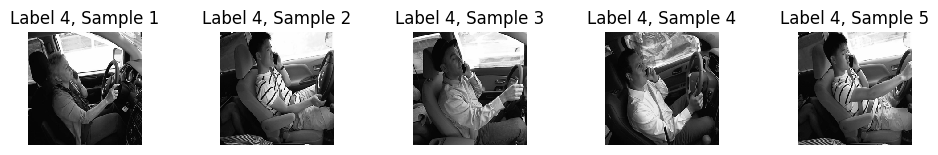

Processed: 25/100 images for 5
Processed: 50/100 images for 5
Processed: 75/100 images for 5
Processed: 100/100 images for 5


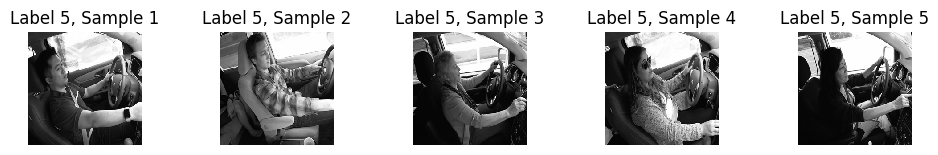

Processed: 25/100 images for 6
Processed: 50/100 images for 6
Processed: 75/100 images for 6
Processed: 100/100 images for 6


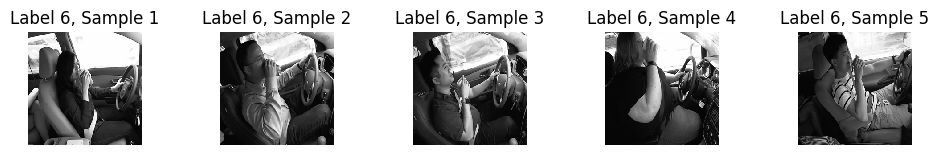

Processed: 25/100 images for 7
Processed: 50/100 images for 7
Processed: 75/100 images for 7
Processed: 100/100 images for 7


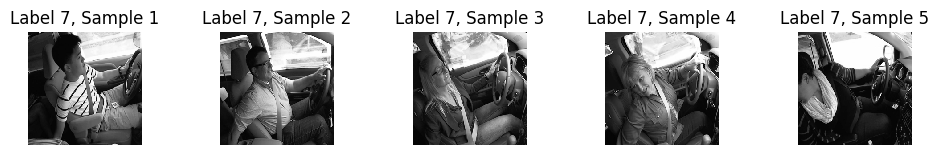

Processed: 25/100 images for 8
Processed: 50/100 images for 8
Processed: 75/100 images for 8
Processed: 100/100 images for 8


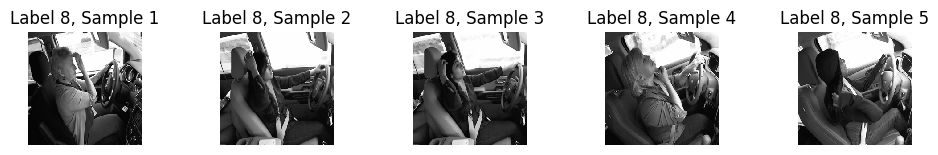

Processed: 25/100 images for 9
Processed: 50/100 images for 9
Processed: 75/100 images for 9
Processed: 100/100 images for 9


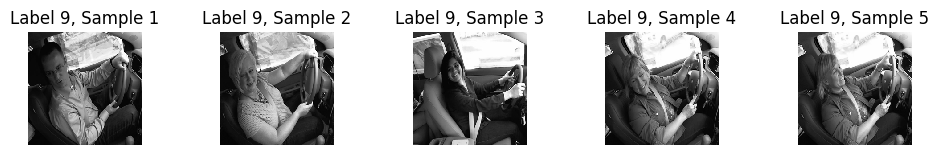

In [11]:
# Process and Split
train_images, val_images, test_images, \
train_labels, val_labels, test_labels = preprocess_images_bulk(*model_inputs)

# Save Training Data
file_path = 'Models_and_Datasets/training_data.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((train_images, train_labels), file)
    
# Save Validation Data
file_path = 'Models_and_Datasets/val_data.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((val_images, val_labels), file)
    
# Save Testing Data
file_path = 'Models_and_Datasets/test_data.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((test_images, test_labels), file)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [13]:
def create_cnn_model(input_shape):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Dense (fully connected) layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))  # Output layer with 10 classes ( 10 classes for distraction types)
    
    return model

# Input images are resized to 256x256 pixels and have 3 color channels (RGB)
input_shape = (256, 256, 1)
cnn_model = create_cnn_model(input_shape)

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# Display the model architecture
cnn_model.summary()

2024-04-22 02:58:29.590070: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-22 02:58:29.590245: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-22 02:58:29.590283: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2024-04-22 02:58:29.593979: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 02:58:29.671558: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 249999

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [16]:
# Convert lists to numpy arrays
train_images_array = np.array(train_images)
val_images_array = np.array(val_images)
test_images_array = np.array(test_images)

train_labels_array = np.array(train_labels)
val_labels_array = np.array(val_labels)
test_labels_array = np.array(test_labels)

# Normalize pixel values to [0, 1]
train_images_normalized = train_images_array / 255.0
val_images_normalized = val_images_array / 255.0
test_images_normalized = test_images_array / 255.0

# Reshape labels if needed (e.g., from list to numpy array)
train_labels_array = np.array(train_labels)
val_labels_array = np.array(val_labels)

# Verify shapes after conversion
print(train_images_normalized.shape)
print(train_labels_array.shape)
print(val_images_normalized.shape)
print(val_labels_array.shape)

: 

: 

In [15]:
# Train the model
cnn_model.fit(train_images_array, train_labels_array, epochs=5, validation_data=(val_images_array, val_labels_array))

2024-04-22 02:58:34.242863: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 209715200 exceeds 10% of free system memory.


Epoch 1/5


ValueError: in user code:

    /home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [32, 256, 256]


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_images_array, test_labels_array)
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# Specify the file path where you want to save the model
model_save_path = r"C:\\Users\\atr8e/OneDrive/Documents/GitHub/Big-Data-Systems/Team 6/Models_and_Datasets/distracted_drivers_cnn_model.h5"

# Save the trained model to the specified file path
cnn_model.save(model_save_path)

print("Model saved successfully at:", model_save_path)